In [10]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['raw_adata', 'full_adata',
             'recluster_0','recluster_1','DE_df',
             'diff_2step_df', 'fet_v_adt_df', 'acr_v_cut_df', 'adt_v_fet_DE','target_v_fol_df',
             'ensembl2symbol_dict'
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
type_order_1 = ['mel',
                'cyc_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()

type_order_2 = ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]

type_order_3 = ['adt_cutaneous_mel',
                'adt_acral_mel',
                'neo_foreskin_mel',
                'fet_cutaneous_mel',
                'fet_acral_mel',
                'fet_dark_foll_mel',
                'fet_light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]


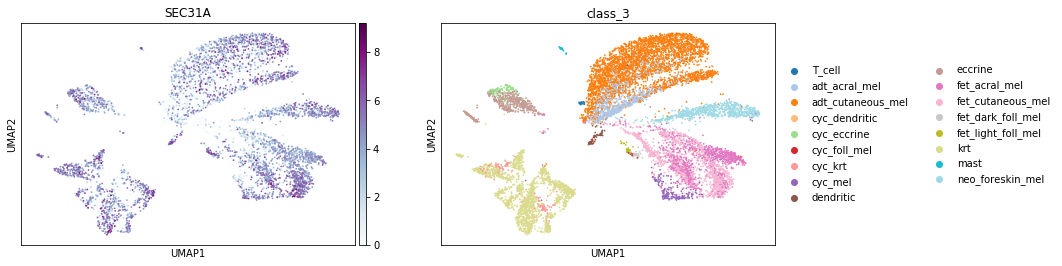

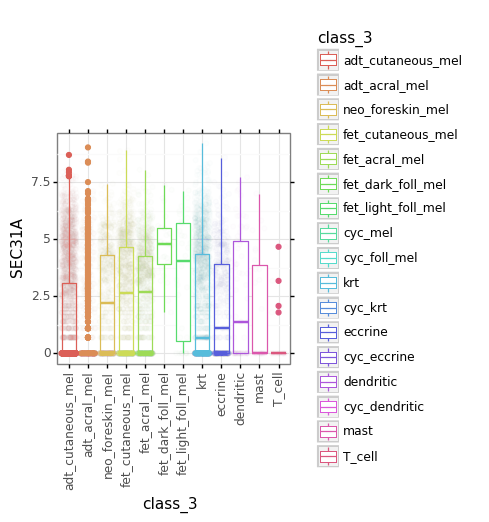

<ggplot: (8762695897885)>
querying 1-1...done.
Finished.
0:  SEC31A 
 The protein encoded by this gene shares similarity with the yeast Sec31 protein, and is a component of the outer layer of the coat protein complex II (COPII). The encoded protein is involved in vesicle budding from the endoplasmic reticulum (ER) and contains multiple WD repeats near the N-terminus and a proline-rich region in the C-terminal half. It associates with the protein encoded by the SEC13 homolog, nuclear pore and COPII coat complex component (SEC13), and is required for ER-Golgi transport. Monoubiquitylation of this protein by CUL3-KLHL12 was found to regulate the size of COPII coats to accommodate unusually shaped cargo. Alternative splicing results in multiple transcript variants encoding different isoforms. [provided by RefSeq, Dec 2015].


In [106]:
# look up gene
gene = 'SEC31A'
groupby = 'class_3'
input_adata = full_adata

sc.pl.umap(input_adata, color = [gene,groupby], cmap='BuPu', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata[[not x.startswith('cyc') \
                                              for x in input_adata.obs[groupby]]],
                            gene,
                            groupby
                           )

plot_df = plot_df.reset_index()
plot_df[groupby] = (plot_df[groupby]
                   .astype(str)
                    .astype(CategoricalDtype(type_order_3,ordered=True))
                   )
plot_df = plot_df.dropna()

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
